In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import random
import numpy
import keras
from keras import layers
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import math

# for consistency
random.seed(4)

## The Data
As per this series, we're using fashion MNIST. 

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) / 255
y_train = y_train.reshape(y_train.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1) / 255
y_test = y_test.reshape(y_test.shape[0], 1)

Our data generation changes a bit here. Now we need triplets, but the overall idea of how we do this is the same.

Note that again, we're just going to create some large number of triplets as a one off thing. This is not optimal, but greatly simplifies other aspects of the example. The bonus examples contain some other demonstrations of what you could do.

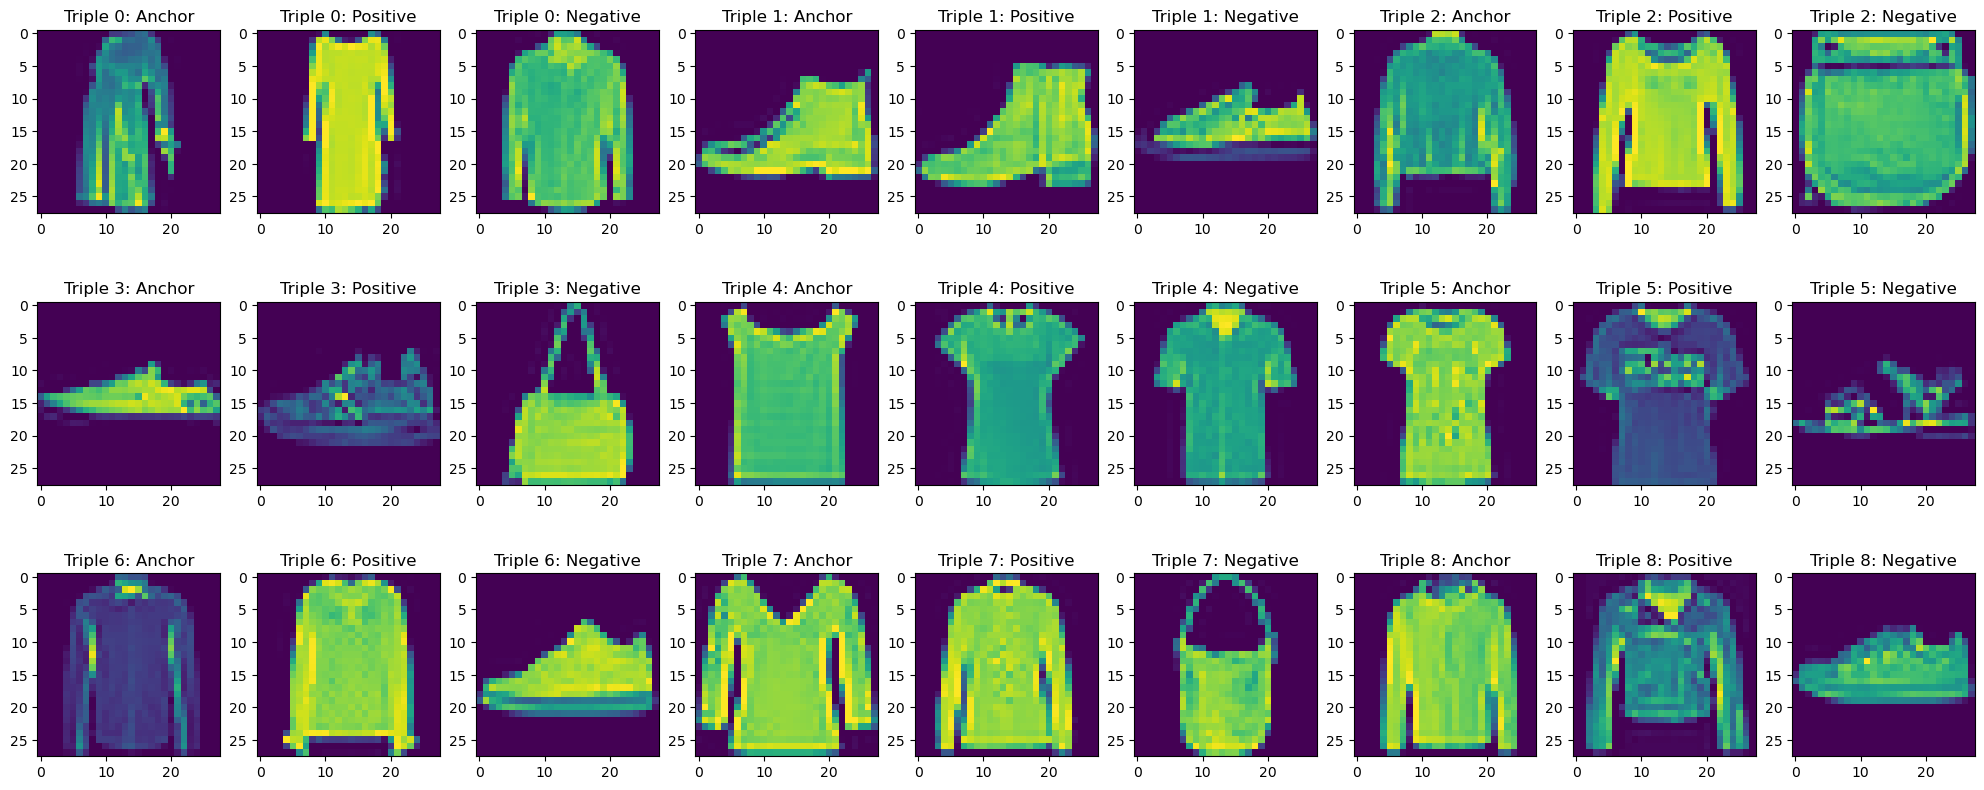

In [3]:
def GetTripletData(imgs, labels, num_samples):

    image_a = numpy.zeros((num_samples, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_b = numpy.zeros((num_samples, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_c = numpy.zeros((num_samples, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
   
    for i in range(num_samples):
        
        idx1 = random.randint(0, len(imgs) - 1)
        idx2 = random.randint(0, len(imgs) - 1)
        idx3 = random.randint(0, len(imgs) - 1)

        while (labels[idx1] != labels[idx2]):
            idx2 = random.randint(0, len(imgs) - 1)            
                
        while (labels[idx1] == labels[idx3]):
            idx3 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        image_c[i, :, :, :] = imgs[idx3,:,:,:]

    return [image_a, image_b, image_c]

x = GetTripletData(x_train, y_train, 9)

fig = plt.figure(figsize=[25, 10])
for i in range(9):
    ax = fig.add_subplot(3, 9, i*3 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Triple ' + str(i) + ': Anchor')
    
    ax = fig.add_subplot(3, 9, i*3 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Triple ' + str(i) + ': Positive')

    ax = fig.add_subplot(3, 9, i*3 + 3)
    ax.imshow(x[2][i,:,:,0])    
    ax.set_title('Triple ' + str(i) + ': Negative')

## The Network
This should be looking familar by now. We'll run with the same network again.

In [4]:
def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):

    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

Create the common branch here, as per last time:
* Create an input
* Create the network with our desired parameters
* Add an embedding layer
* Turn that into a model

In [5]:
embedding_size = 32
dummy_input = keras.Input((28, 28, 1))
base_network = vgg_net(dummy_input, [8, 16, 32], [256], 0.2, 0)
embedding_layer = layers.Dense(embedding_size, activation=None)(base_network)
base_network = keras.Model(dummy_input, embedding_layer, name='SiameseBranch')

### New Stuff
Again, something different here.

#### Triplet Loss Formulation

As per last time, we'll take moment to consider the maths. We now have three images, we're going to call then:
* $a$: the anchor
* $p$: the positive image, this is the same class as the anchor
* $n$: the negative image, this is a different class to the anchor

From these three images we can get two distances, using some distance function of our choosing:
* $d(a,p)$: which is the distance between the anchor and positive image. We want this to be small.
* $d(a,n)$: which is the distance between the anchor and negative image. We want this to be big.

From this, we get our triplet loss:

$L_{triplet} = max(d(a,p) - d(a,n) + margin, 0)$

If $d(a,p) - d(a,n) > margin$, then our loss will return $0$, otherwise it will return a positive value which indicates how far short of $margin$ the difference is. As with the contrastive loss, the aim of the network is to get embeddings of the same class close to one another, and embeddings from different classes far away; but now we can do this all at once as a single input to the network contains a positive and a negative pair.

#### Triplet Loss Implementation

Again, I'm borrowing. This time from [here](https://medium.com/@crimy/one-shot-learning-siamese-networks-and-triplet-loss-with-keras-2885ed022352), where there's a rather nice triplet loss layer implementation (incidently, there's some other interesting stuff in that post too that may be of interest).

Why use a layer for our loss and not just a function? Really it comes down to a practical choice, and it being easier to wrangle the three inputs (anchor, positive and negative) in a layer. Also, it's good to demonstrate custom layer creation.

In [6]:
def normalise_vector(vect):
    # get the magnitude for each vector in the batch
    mag = keras.ops.sqrt(keras.ops.sum(keras.ops.square(vect), axis=1))
    # repeat this, so we now have as many elements in mag as we do in vect
    mag = keras.ops.reshape(keras.ops.repeat(mag, vect.shape[1], axis=0), (-1, vect.shape[1]))
    # element wise division
    return keras.ops.divide(vect, mag)

class TripletLossLayer(layers.Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        
        anchor = normalise_vector(anchor)
        positive = normalise_vector(positive)
        negative = normalise_vector(negative)

        p_dist = keras.ops.sum(keras.ops.square(anchor-positive), axis=-1)
        n_dist = keras.ops.sum(keras.ops.square(anchor-negative), axis=-1)
        return keras.ops.sum(keras.ops.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
        
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss


In [7]:
input_anchor = keras.Input((28, 28, 1), name='Anchor')
input_positive = keras.Input((28, 28, 1), name='Positive')
input_negative = keras.Input((28, 28, 1), name='Negative')
embedding_anchor = base_network(input_anchor)
embedding_positive = base_network(input_positive)
embedding_negative = base_network(input_negative)

margin = 1
loss_layer = TripletLossLayer(alpha=margin, name='triplet_loss_layer')([embedding_anchor, embedding_positive, embedding_negative])

Note that we have a slightly weird setup here. Our loss is the layer, and we have no actual layers in our network (sort-of, the whole base network is there, it's just kind-of hidden). As the inputs are triplets and we simply seek to minimise a distance between the triplets, we don't need any labels - we just want to make the output of this as small as possible.

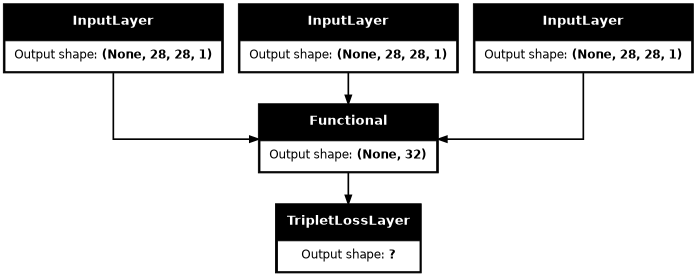

In [8]:
triplet_network = keras.Model(inputs=[input_anchor, input_positive, input_negative], outputs=loss_layer)
# as per previous example, if you want the full network set expand_nested=True
keras.utils.plot_model(triplet_network, show_shapes=True, dpi = 60, expand_nested=False)

And now we can train our network, much like we have before.

In [9]:
batch_size = 128
triplet_network.compile(optimizer=keras.optimizers.Adam(), jit_compile=False)
triplet_train_x = GetTripletData(x_train, y_train, 60000)
triplet_test_x = GetTripletData(x_test, y_test, 10000)
triplet_network.fit(x=triplet_train_x, y=None, batch_size=batch_size, epochs=10, validation_data=(triplet_test_x, None))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 41ms/step - loss: 35.3171 - val_loss: 17.9062
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 17.6017 - val_loss: 14.5418
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 14.3882 - val_loss: 13.3344
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 13.1383 - val_loss: 13.9175
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 12.2652 - val_loss: 18.8453
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 11.6117 - val_loss: 13.4464
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 11.4676 - val_loss: 12.9729
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 10.7381 - val_loss: 17.4708
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 10.6673 - val_loss: 14.5171
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 10.2461 - val_loss: 12.8861


## The Results
Let's have a look at some outputs.

We'll start with just a random 10 samples and see what it returns. For extra info, we'll plot the raw score out of the network rather than the rounded result, and show the expected score in brackets.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


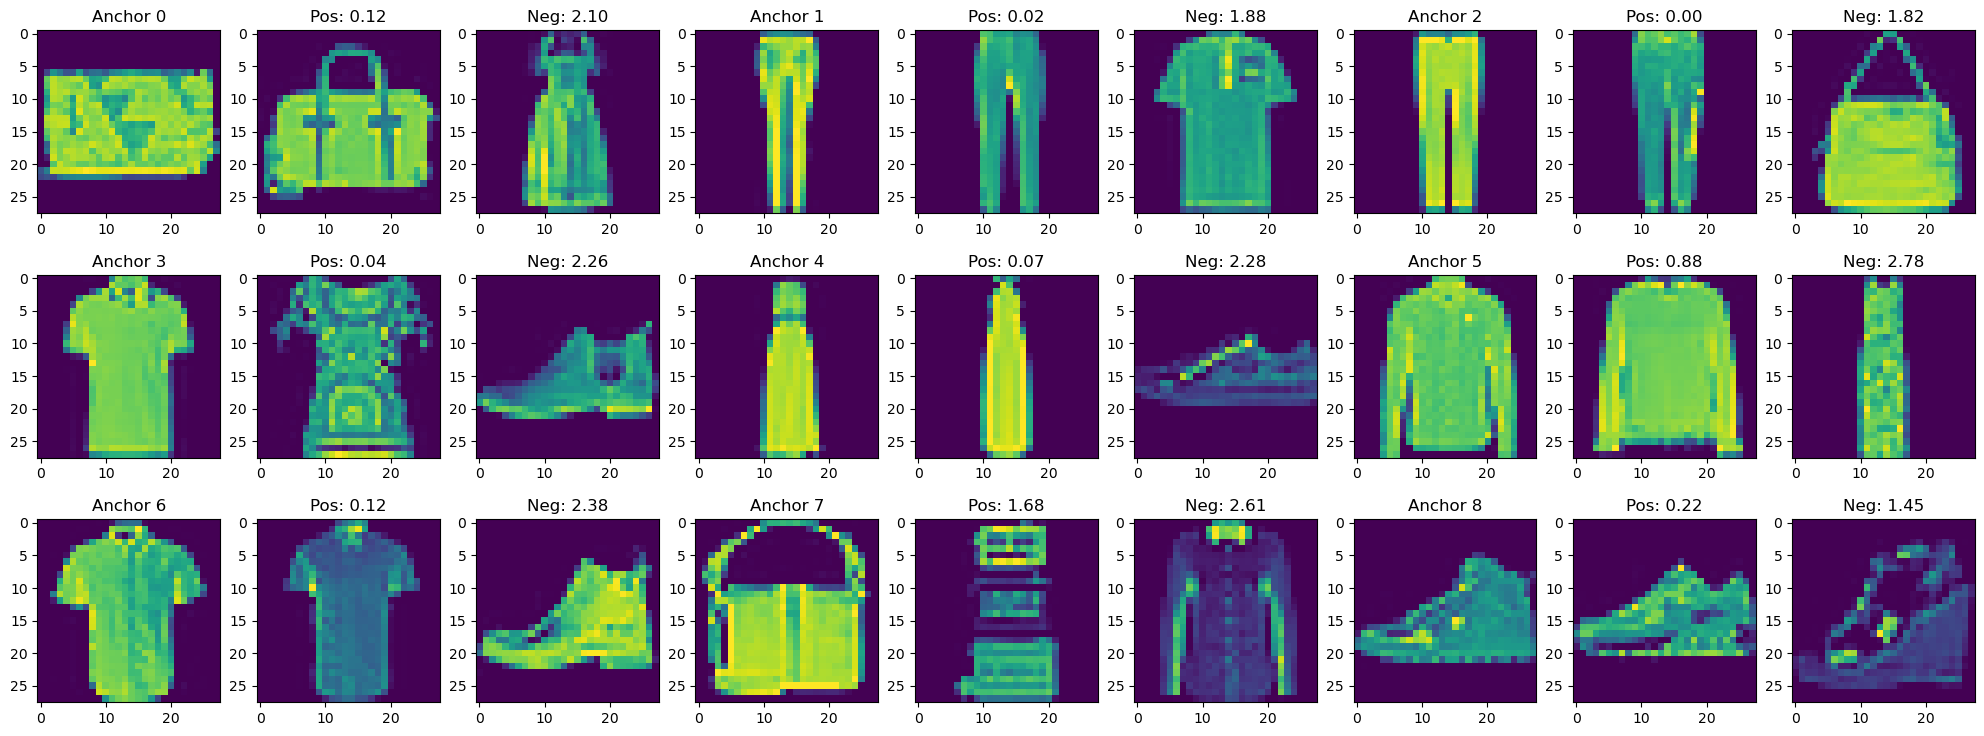

In [10]:
def ComputeDistance(x, y):
    x = normalise_vector(x)
    y = normalise_vector(y)
    dist = keras.ops.sum(keras.ops.square(x - y), axis=-1)
    return dist

x = GetTripletData(x_test, y_test, 9)
anchor_embedding = base_network.predict(x[0])
positive_embedding = base_network.predict(x[1])
negative_embedding = base_network.predict(x[2])
pos_dists = ComputeDistance(anchor_embedding, positive_embedding)
neg_dists = ComputeDistance(anchor_embedding, negative_embedding)

fig = plt.figure(figsize=[25, 9])
for i in range(9):
    ax = fig.add_subplot(3, 9, i*3 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Anchor ' + str(i))
    
    ax = fig.add_subplot(3, 9, i*3 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Pos: ' + '%1.2f' % float(pos_dists[i]))
    
    ax = fig.add_subplot(3, 9, i*3 + 3)
    ax.imshow(x[2][i,:,:,0])    
    ax.set_title('Neg: ' + '%1.2f' % float(neg_dists[i]))

This looks pretty good. In general, we've got a much bigger gap between our positive and negative examples.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


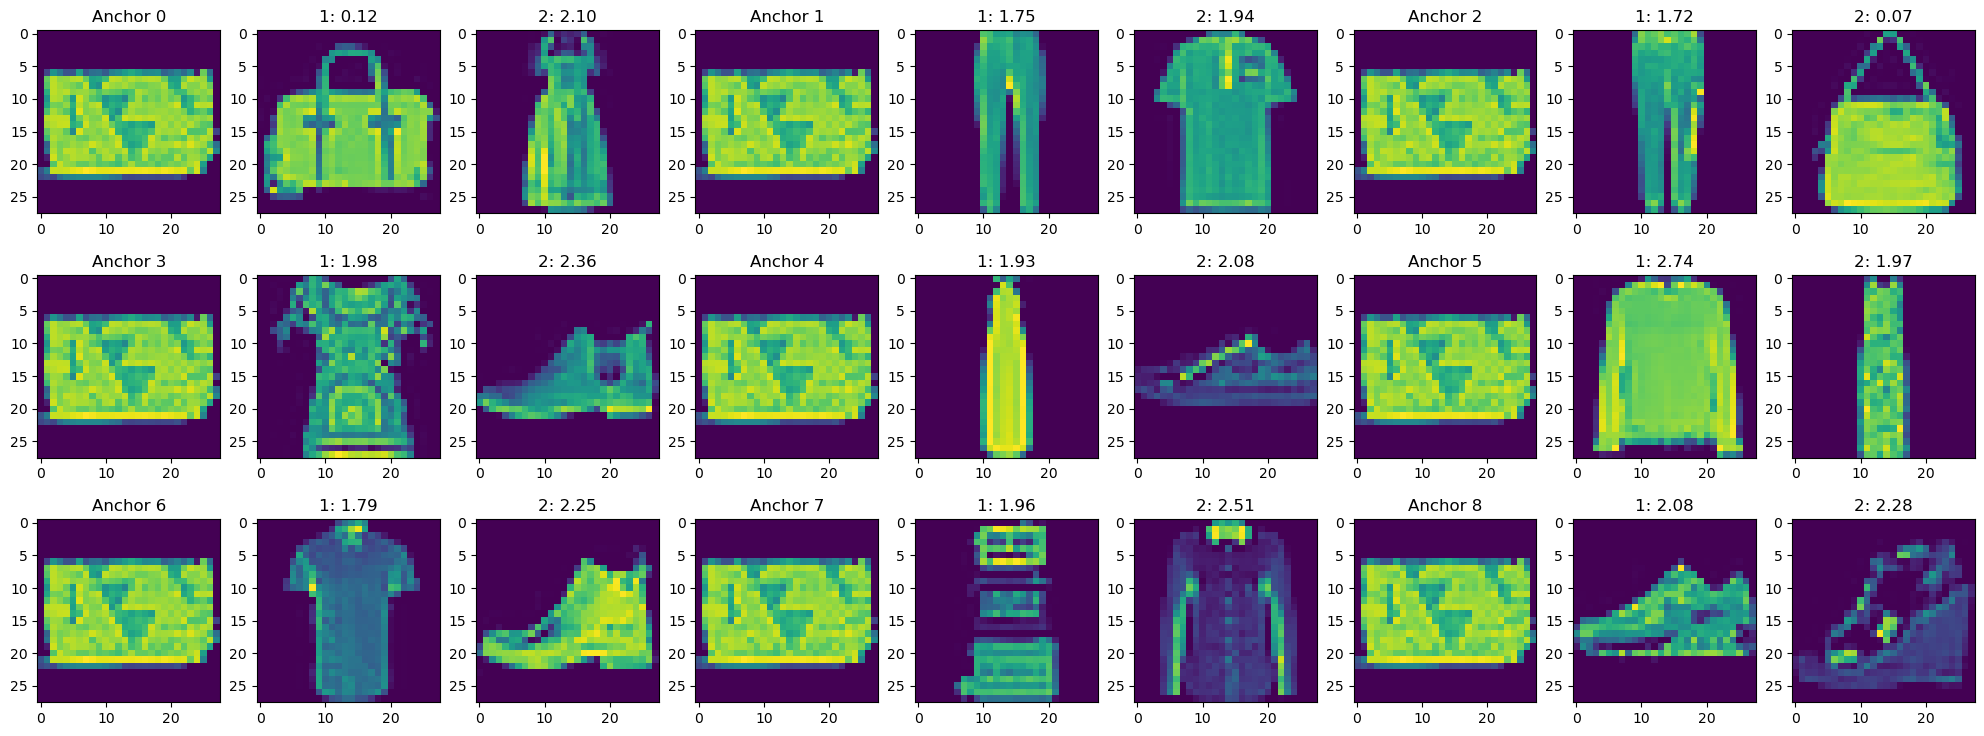

In [11]:
for i in range(9):
    x[0][i,:] = x[0][0,:]

anchor_embedding = base_network.predict(x[0])
positive_embedding = base_network.predict(x[1])
negative_embedding = base_network.predict(x[2])
pos_dists = ComputeDistance(anchor_embedding, positive_embedding)
neg_dists = ComputeDistance(anchor_embedding, negative_embedding)

fig = plt.figure(figsize=[25, 9])
for i in range(9):
    ax = fig.add_subplot(3, 9, i*3 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Anchor ' + str(i))
    
    ax = fig.add_subplot(3, 9, i*3 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('1: ' + '%1.2f' % float(pos_dists[i]))
    
    ax = fig.add_subplot(3, 9, i*3 + 3)
    ax.imshow(x[2][i,:,:,0])    
    ax.set_title('2: ' + '%1.2f' % float(neg_dists[i]))

Looking at the above examples is also promising, and the distributions below show better separation between the positive and negative cases. It's still not perfect (far from it), but on the whole heading in the right direction.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step


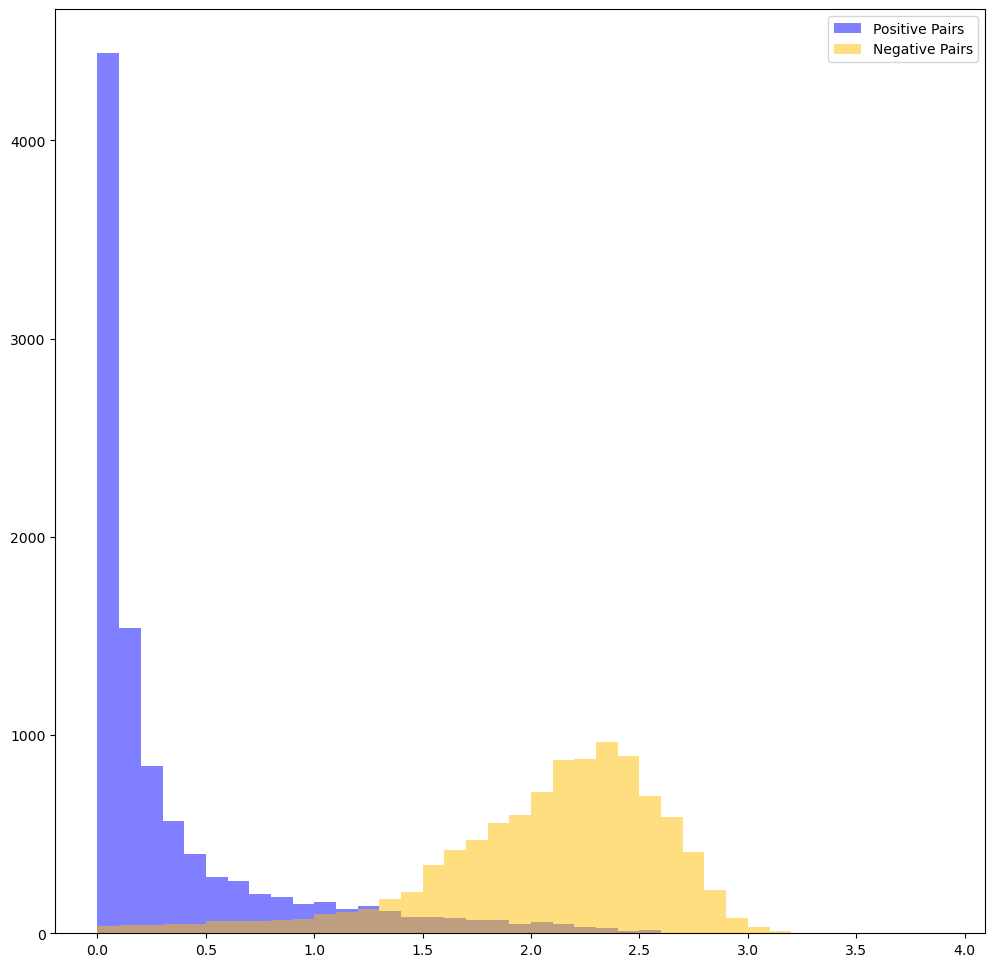

In [12]:
anchor_embedding = base_network.predict(triplet_test_x[0])
positive_embedding = base_network.predict(triplet_test_x[1])
negative_embedding = base_network.predict(triplet_test_x[2])

positive_distances = ComputeDistance(anchor_embedding, positive_embedding)
negative_distances = ComputeDistance(anchor_embedding, negative_embedding)

fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.hist(positive_distances, numpy.arange(0, 4.0, 0.1), label='Positive Pairs', fc=(0, 0, 1.0, 0.5))
ax.hist(negative_distances, numpy.arange(0, 4.0, 0.1), label='Negative Pairs', fc=(1.0, 0.75, 0, 0.5))
ax.legend();

Finally we come to the embeddings, and we see again that these look promising. The groups are perhaps not as compact as we'd like, and there is still some confusion between classes, but it's much better than the binary cross entropy loss and at least as good, if not better, than the contrastive loss case. 

As noted in the summary below, we also need to remember that:
* Our network is very simple
* Our embedding is very small
* We haven't trained the network for that long

Changing any (or all) of these would lead to better performance again.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step


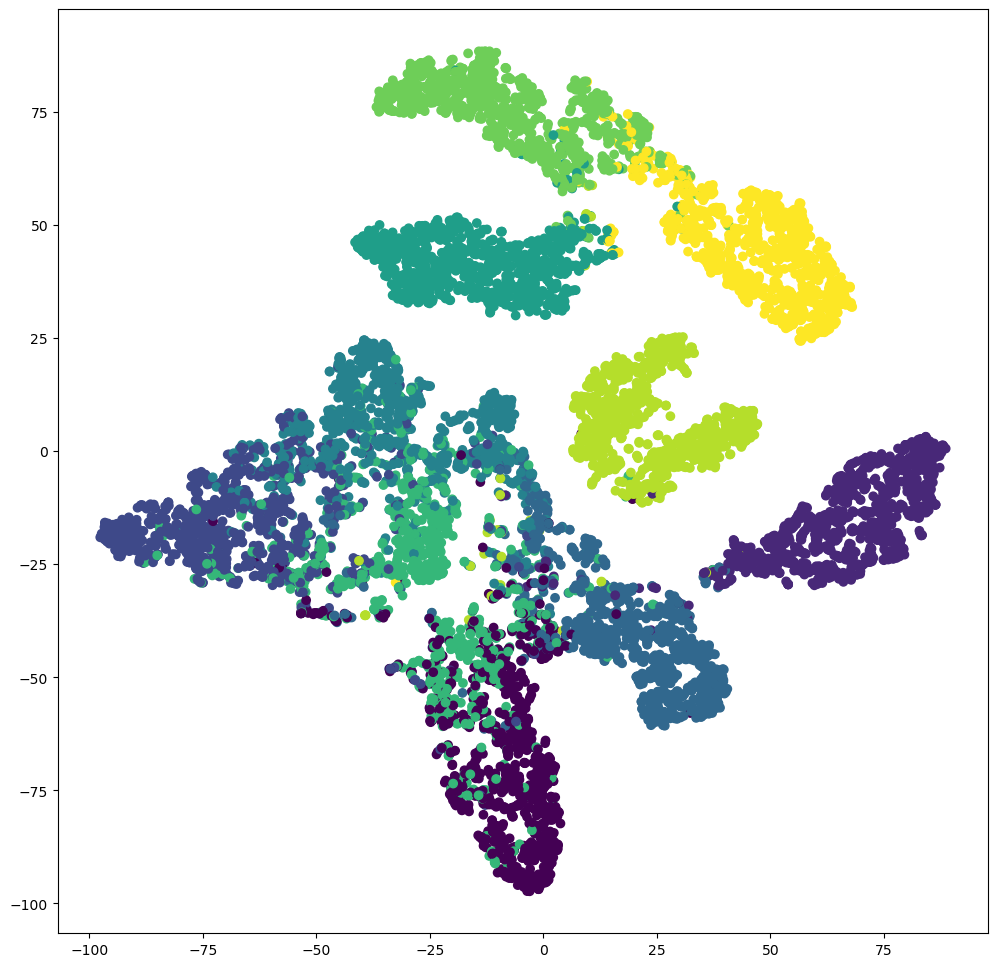

In [13]:
embeddings = base_network.predict(x_test)
tsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = y_test.flatten());

## Final Thoughts

So what have we learnt today?

It's worth reflecting on the three formulations that we've considered for this task, where we've used
* Binary Cross Entropy (BCE) Loss;
* Contrastive Loss; and
* Triplet Loss.

With all of these we've used the same, simple network - yet got quite different results. All we've really changed is the loss function. It's very easy to get carried away with deep nets and keep adding layer after layer, making them more complex in the hope that they'll learn more or learn better. Often though, quite dramatic results can be achieved by tweaking the loss function. Consider out BCE loss, it only cared if two things were the same class. It could do that ok, but the embedding that it learned wasn't necessarily useful for other tasks, like ranking or grouping similar things. With the contrastive loss, we improved this somewhat, but our loss was most interested in making sure that different things were far enough away from each other. As such, the distances in general got pushed out.

The triplet loss was able to do a much better job. By having each example now contain a set of three images, containing a matching pair and a non-matching pair, each example was now able to guide the network to make the matching images closer together than the mismatching pair, while also attempting to force the mismatching pair to be further apart than some margin. This results in a much better end result, and while classes aren't perfectly separated, it's better than it was.

So, at this point it'a also fair to ask, how much further can (or should) this go? We could further and improve performance by:
* Adding another image to expose the network to more diverse negative pairs; i.e. get two negative distances per example through the network.
* Adding another margin to control the distance between the positive pairs; i.e. force positives images to be no further apart than some distance.

However, while both these will help performance, returns will also begin to diminish. We also at likely at the point where our underlying network is limiting performance. We have got a very simple VGG-like network sitting behind this, and we've also got quite a small embedding of size 32. Increasing one or both of these may also improve performance.

One other point worth mentioning is that different things can be done with both the distance metric and the embeddings themselves. For example we could switch to using another metric such as the cosine distance (i.e. the angle between the vectors/embeddings).

Finally, one point worth making is that we don't need to train these networks from scratch. We could just as easily pick a network thats been trained for an image classification type task, remove the layers we don't need, and fine tune from that. The vast majority of methods in the literature that use this sort of architecture do exactly that.